## Results and evaluation

In [1050]:
import numpy as np
import pandas as pd
import dateutil as dt
from sklearn import metrics
import json

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import notebook_utils

In [1051]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1052]:
group = 'unseen'
#group = 'embeddings'
group = 'test'

In [1053]:
with open(f'../output/links_{group}.txt') as f:
    link_refs = f.readlines()
    link_refs = list(filter(lambda x: not x.startswith('#'), [x.strip() for x in link_refs]))

In [1054]:
link_refs

['1776:1742', '21:53095', '53095:23', '1217:1218', '48844:1672', '2342:1450']

In [1055]:
times = ['20190415']

In [1154]:
results = []
hyperparameters = []
models = ['baseline_nn', 'day_type_embeddings']
#models = ['baseline_nn']
#models = ['day_type_embeddings']

for model in models:
    for link_ref in link_refs:
        link_ref_slug = link_ref.replace(':', '-')    
        output_directory = f'../output/{model}/{group}/{link_ref_slug}'
        for time in times:
            try:
                time_slug = time # time.date().isoformat().replace('-', '')                
                train = pd.read_csv(f'{output_directory}/train_{time_slug}.csv', index_col = 0)
                test = pd.read_csv(f'{output_directory}/test_{time_slug}.csv', index_col = 0)
                hist = pd.read_csv(f'{output_directory}/hist_{time_slug}.csv', index_col = 0)
                
                results.append({
                    'link_ref': link_ref,
                    'time': time,
                    'model': model,
                    'test_mean_absolute_error': metrics.mean_absolute_error(test['link_travel_time_exp'], test[model]),
                    'test_root_mean_squared_error': np.sqrt(metrics.mean_squared_error(test['link_travel_time_exp'], test[model])),
                    'train_mean_absolute_error': metrics.mean_absolute_error(train['link_travel_time_exp'], train[model]),
                    'train_root_mean_squared_error': np.sqrt(metrics.mean_squared_error(train['link_travel_time_exp'], train[model]))
                })
            except Exception as e:
                print(f'Failed to add {model} / {link_ref} / {time}', e)
                pass

        try:
            with open(f'{output_directory}/hyperparameters.json') as f:
                model_hyperparameters = json.load(f)['values']
            model_hyperparameters['link_ref'] = link_ref
            model_hyperparameters['model'] = model
            hyperparameters.append(model_hyperparameters)
        except Exception as e:
            print(f'Failed to add {model} / {link_ref} / {time}', e)
            pass

results = pd.DataFrame(results)

hyperparameters = pd.DataFrame(hyperparameters).drop(['tuner/bracket', 'tuner/epochs', 'tuner/initial_epoch', 'tuner/round', 'tuner/trial_id'], axis = 1)
#hyperparameters.loc[hyperparameters['num_layers'] < 3, 'units_3'] = 0
#hyperparameters.loc[hyperparameters['num_layers'] < 2, 'units_2'] = 0

In [1155]:
hyperparameters.set_index(['model', 'link_ref'])

dropout  num_layers  fc_1_units  \
model               link_ref                                      
baseline_nn         1776:1742       0.2           2         400   
                    21:53095        0.2           2         400   
                    53095:23        0.0           2         200   
                    1217:1218       0.2           2         350   
                    48844:1672      0.2           3         500   
                    2342:1450       0.2           2         400   
day_type_embeddings 1776:1742       0.2           1         300   
                    21:53095        0.2           1         250   
                    53095:23        0.0           2         150   
                    1217:1218       0.1           1         350   
                    48844:1672      0.2           2         250   
                    2342:1450       0.1           2         200   

                               fc_1_activation  learning_rate  momentum  \
model               link_ref                                              
baseline_nn         1776:1742             tanh          0.001      0.85   
                    21:53095              relu          0.010      0.75   
                    53095:23              tanh          0.010      0.65   
                    1217:1218             tanh          0.001      0.65   
                    48844:1672            tanh          0.010      0.65   
                    2342:1450             tanh          0.001      0.85   
day_type_embeddings 1776:1742             relu          0.001      0.85   
                    21:53095              relu          0.001      0.75   
                    53095:23              relu          0.001      0.65   
                    1217:1218             relu          0.010      0.75   
                    48844:1672            tanh          0.010      0.65   
                    2342:1450             relu          0.001      0.85   

                                decay  batch_size  batch_norm  fc_2_units  \
model               link_ref                                                
baseline_nn         1776:1742    0.95          50           0         100   
                    21:53095     0.95          50           0         500   
                    53095:23     1.00        1000           1         100   
                    1217:1218    0.95         100           1         200   
                    48844:1672   0.95          50           1         500   
                    2342:1450    0.95          50           0         100   
day_type_embeddings 1776:1742    1.00          50           1         400   
                    21:53095     0.95        1000           1         150   
                    53095:23     0.95        1000           0         400   
                    1217:1218    1.00         100           1         100   
                    48844:1672   0.95        1000           0         200   
                    2342:1450    1.00         100           1         350   

                               fc_2_activation  fc_3_units fc_3_activation  \
model               link_ref                                                 
baseline_nn         1776:1742             tanh       450.0            tanh   
                    21:53095              tanh       100.0            relu   
                    53095:23              relu       150.0            tanh   
                    1217:1218             tanh       400.0            tanh   
                    48844:1672            tanh       200.0            tanh   
                    2342:1450             tanh       450.0            tanh   
day_type_embeddings 1776:1742             tanh       100.0            relu   
                    21:53095              tanh       300.0            tanh   
                    53095:23              relu       400.0            relu   
                    1217:1218             relu         NaN             NaN   
                    48844:1

In [1156]:
#results[lambda x: ~x['link_ref'].isin(['1776:1742', '21:53095', '48844:1672', '1217:1218', '53095:23'])].groupby(['model', 'link_ref', 'time'])['root_mean_squared_error']
a = results.set_index(['link_ref', 'model'])['test_root_mean_squared_error'].unstack(1).round(1)
a.style.apply(notebook_utils.highlight_min, axis = 1)

model,baseline_nn,day_type_embeddings
link_ref,,
1217:1218,3.100000,2.900000
1776:1742,22.000000,24.000000
21:53095,3.800000,2.900000
2342:1450,7.800000,9.500000
48844:1672,7.300000,7.600000
53095:23,6.600000,6.400000


In [1157]:
#results[lambda x: ~x['link_ref'].isin(['1776:1742', '21:53095', '53095:23', '10842:10596', '2089:52737', '1218:750'])].groupby(['model'])[['test_mean_absolute_error', 'test_root_mean_squared_error']].mean().round(1).style.apply(notebook_utils.highlight_min, axis = 0)
results.groupby(['model'])[['test_mean_absolute_error', 'test_root_mean_squared_error']].mean().round(1).style.apply(notebook_utils.highlight_min, axis = 0)

,test_mean_absolute_error,test_root_mean_squared_error
model,,
baseline_nn,6.300000,8.400000
day_type_embeddings,7.100000,8.900000


Overfitting:
1217:1218
53095:23

In [1189]:
link_ref = '1217:1218' #'1417:27686'
link_ref_slug = link_ref.replace(':', '-')    

train = pd.DataFrame(columns=['link_travel_time', 'link_travel_time_exp']) 
test = pd.DataFrame()
hp_hist = pd.DataFrame(index = np.arange(99) + 1)
hist = pd.DataFrame(index = np.arange(99) + 1)

for model in models:
    output_directory = f'../output/{model}/{group}/{link_ref_slug}'
    train_ = pd.read_csv(f'{output_directory}/train_{time_slug}.csv', index_col = 0, parse_dates=True)
    train_ = train_.loc[~train_.index.duplicated(keep='first')]
    train = train.join(train_[model], how='outer')
    train.loc[train_.index, 'link_travel_time'] = train_['link_travel_time']
    train.loc[train_.index, 'link_travel_time_exp'] = train_['link_travel_time_exp']
    test_ = pd.read_csv(f'{output_directory}/test_{time_slug}.csv', index_col = 0, parse_dates=True)
    if not 'link_travel_time_exp' in test.columns and 'link_travel_time_exp' in test_.columns:
        test['link_travel_time_exp'] = test_['link_travel_time_exp']
    test[model] = test_[model]
    hp_hist[model + '_loss'] = pd.read_csv(f'{output_directory}/hp_hist_{time_slug}.csv', index_col = 0)['loss']
    hp_hist[model + '_val_loss'] = pd.read_csv(f'{output_directory}/hp_hist_{time_slug}.csv', index_col = 0)['val_loss']
    hist[model + '_loss'] = pd.read_csv(f'{output_directory}/hist_{time_slug}.csv', index_col = 0)['loss']
    hist[model + '_val_loss'] = pd.read_csv(f'{output_directory}/hist_{time_slug}.csv', index_col = 0)['val_loss']
    
hp_hist = hp_hist.dropna(how='all')
hist = hist.dropna(how='all')

In [1190]:
test_

,link_travel_time,link_travel_time_exp,mean,std,day_type_embeddings
time,,,,,
2019-04-15 00:14:46,34,38.6,36.60241,8.959289,36.617338
2019-04-15 00:36:15,82,38.7,36.60241,8.959289,35.489072
2019-04-15 01:27:13,32,37.9,36.60241,8.959289,36.420279
2019-04-15 02:29:10,36,37.5,36.60241,8.959289,35.979430
2019-04-15 04:23:44,30,37.2,36.60241,8.959289,36.208883
...,...,...,...,...,...
2019-04-21 22:04:57,34,40.8,36.60241,8.959289,33.904318
2019-04-21 22:37:27,36,41.6,36.60241,8.959289,33.775077
2019-04-21 22:57:31,32,41.8,36.60241,8.959289,32.624451


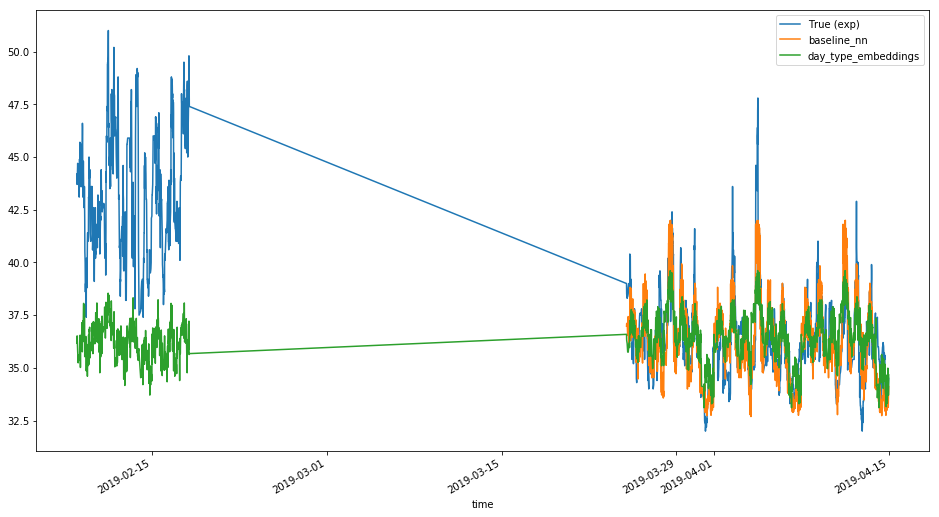

In [1191]:
fig, ax = plt.subplots(figsize = (16, 9))
train['link_travel_time_exp'].plot(ax = ax, label = 'True (exp)')
for model in models:
    #notebook_utils.smooth_align_df(test[[model]], freq = '5min', smooth=50).plot(ax = ax)
    train[model].plot(ax = ax)
ax.legend()

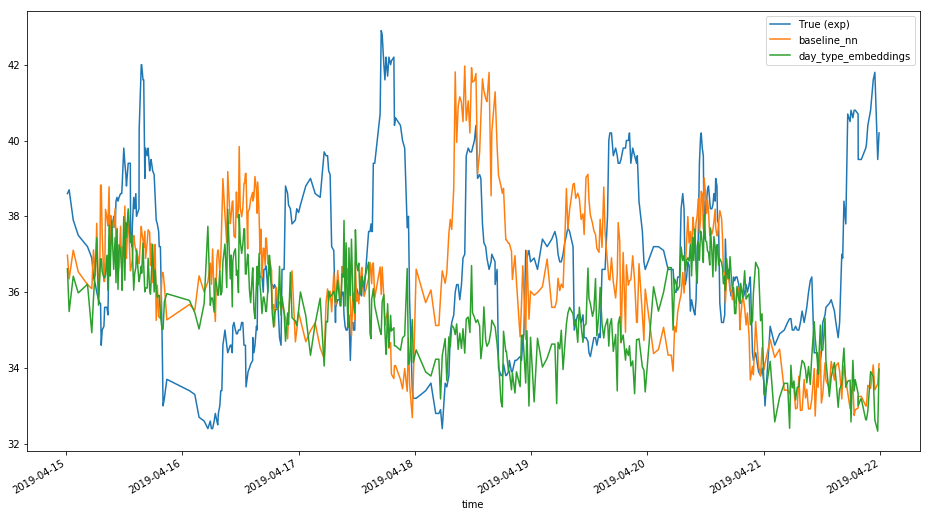

In [1192]:
fig, ax = plt.subplots(figsize = (16, 9))
test['link_travel_time_exp'].plot(ax = ax, label = 'True (exp)')
for model in models:
    #notebook_utils.smooth_align_df(test[[model]], freq = '5min', smooth=50).plot(ax = ax)
    test[model].plot(ax = ax)
ax.legend()

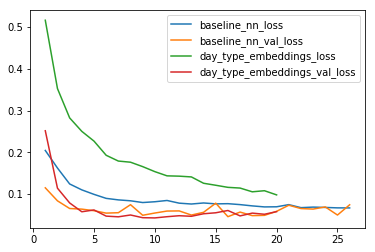

In [1162]:
hp_hist.plot()

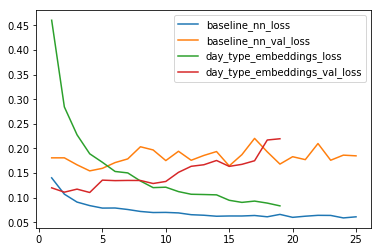

In [1163]:
hist.plot()